In [1]:
using DataFrames
using Plots
using StatsPlots
using CSV
using Flux
using Statistics
using ScikitLearn
using Random

In [2]:
# Load custom functions from provided files
include("preprocessing.jl")
include("metrics.jl")
include("plotting.jl")
include("training.jl")

┌ Warning: Failed to load integration with PlotlyBase & PlotlyKaleido.
│   exception = (ArgumentError("Package PlotlyBase not found in current path.\n- Run `import Pkg; Pkg.add(\"PlotlyBase\")` to install the PlotlyBase package."), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007ff991523777, Ptr{Nothing} @0x00007ff990f0c2b4, Ptr{Nothing} @0x00007ff9c9d796fe, Ptr{Nothing} @0x00007ff99227ff9b, Ptr{Nothing} @0x00007ff9925a2c74, Ptr{Nothing} @0x00007ff9c9da9bd2, Ptr{Nothing} @0x00007ff9c9dabaa6, Ptr{Nothing} @0x00007ff9c9d8dafa, Ptr{Nothing} @0x00007ff9c9d8e31e, Base.InterpreterIP in top-level CodeInfo for Main at statement 0, Ptr{Nothing} @0x00007ff9c9daadf8, Ptr{Nothing} @0x00007ff9c9dac576, Ptr{Nothing} @0x000001926269020e, Ptr{Nothing} @0x0000019262690a08, Ptr{Nothing} @0x0000019262696ed6, Ptr{Nothing} @0x0000019262696f04, Ptr{Nothing} @0x00007ff9c9d8cc7a, Ptr{Nothing} @0x00007ff9c9d8c774, Ptr{Nothing} @0x00007ff9c9d8d3c0, Ptr{Nothing} @0x00007ff9c9d8e31e, Base.Interpreter

trainClassEnsemble (generic function with 13 methods)

In [3]:
# Set the random seed for reproducibility
Random.seed!(42)

# Load the dataset
dataset_path = "dataset.csv"
data = CSV.read(dataset_path, DataFrame)

Row,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,Float64,String15
1,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout
2,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.0,0,0,6,6,6,13.6667,0,13.9,-0.3,0.79,Graduate
3,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.0,0,0,6,0,0,0.0,0,10.8,1.4,1.74,Dropout
4,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.4286,0,0,6,10,5,12.4,0,9.4,-0.8,-3.12,Graduate
5,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.3333,0,0,6,6,6,13.0,0,13.9,-0.3,0.79,Graduate
6,2,12,1,17,0,12,1,22,27,10,8,0,0,1,1,1,0,50,0,0,5,10,5,11.8571,0,0,5,17,5,11.5,5,16.2,0.3,-0.92,Graduate
7,1,1,1,12,1,1,1,13,28,8,11,1,0,0,1,0,1,18,0,0,7,9,7,13.3,0,0,8,8,8,14.345,0,15.5,2.8,-4.06,Graduate
8,1,9,4,11,1,1,1,22,27,10,10,1,0,0,0,1,0,22,0,0,5,5,0,0.0,0,0,5,5,0,0.0,0,15.5,2.8,-4.06,Dropout
9,1,1,3,10,1,1,15,1,1,10,10,0,0,0,1,0,1,21,1,0,6,8,6,13.875,0,0,6,7,6,14.1429,0,16.2,0.3,-0.92,Graduate


In [4]:
# Separate features and target
target_column = :Target
inputs = select(data, Not(target_column))
targets = data[!, target_column]

4424-element PooledArrays.PooledVector{String15, UInt32, Vector{UInt32}}:
 "Dropout"
 "Graduate"
 "Dropout"
 "Graduate"
 "Graduate"
 "Graduate"
 "Graduate"
 "Dropout"
 "Graduate"
 "Dropout"
 ⋮
 "Dropout"
 "Graduate"
 "Graduate"
 "Graduate"
 "Graduate"
 "Dropout"
 "Dropout"
 "Graduate"
 "Graduate"

# EDA

In [5]:
# Summary Statistics
println("Summary Statistics:")
println(describe(data))

Summary Statistics:
35×7 DataFrame
 Row │ variable                           mean        min      median   max       nmissing  eltype   
     │ Symbol                             Union…      Any      Union…   Any       Int64     DataType 
─────┼───────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Marital status                     1.17857     1        1.0      6                0  Int64
   2 │ Application mode                   6.88698     1        8.0      18               0  Int64
   3 │ Application order                  1.72785     0        1.0      9                0  Int64
   4 │ Course                             9.89919     1        10.0     17               0  Int64
   5 │ Daytime/evening attendance         0.890823    0        1.0      1                0  Int64
   6 │ Previous qualification             2.53142     1        1.0      17               0  Int64
   7 │ Nacionality                        1.25452     1        1.0     

In [6]:
# Identify Numeric and Categorical Features
categorical_columns = ["Marital status", "Application mode", "Course", "Daytime/evening attendance", "Previous qualification",
                        "Nacionality", "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation",
                        "Displaced", "Educational special needs", "Debtor", "Tuition fees up to date", "Gender", "Scholarship holder",
                        "International"]

numeric_columns = setdiff(names(inputs), categorical_columns)  # Remaining columns are treated as numeric                      

println("\nNumeric Columns: ", numeric_columns)
println("Categorical Columns: ", categorical_columns)
println("There are ", length(numeric_columns), " numeric columns and ", length(categorical_columns), " categorical columns.")


Numeric Columns: ["Application order", "Age at enrollment", "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)", "Curricular units 1st sem (evaluations)", "Curricular units 1st sem (approved)", "Curricular units 1st sem (grade)", "Curricular units 1st sem (without evaluations)", "Curricular units 2nd sem (credited)", "Curricular units 2nd sem (enrolled)", "Curricular units 2nd sem (evaluations)", "Curricular units 2nd sem (approved)", "Curricular units 2nd sem (grade)", "Curricular units 2nd sem (without evaluations)", "Unemployment rate", "Inflation rate", "GDP"]
Categorical Columns: ["Marital status", "Application mode", "Course", "Daytime/evening attendance", "Previous qualification", "Nacionality", "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", "Displaced", "Educational special needs", "Debtor", "Tuition fees up to date", "Gender", "Scholarship holder", "International"]
There are 17 numeric columns and 17 

In [9]:
# Check for missing values
println("Checking for missing values...")
missing_counts = sum(ismissing, eachcol(data))
if any(missing_counts .> 0)
    println("Missing values found in the following columns:")
    println(names(data)[missing_counts .> 0])
    # Handle missing values (example: dropping rows with missing values)
    data = dropmissing(data)
    println("Missing values handled. Dataset size after cleaning: ", size(data))
else
    println("No missing values found.")
end

Checking for missing values...
No missing values found.


In [10]:
# Check Class Balance for the Target Column
target_column = :Target
println("\nClass Distribution:")
println(combine(groupby(data, target_column), nrow => :Count))


Class Distribution:
3×2 DataFrame
 Row │ Target    Count 
     │ String15  Int64 
─────┼─────────────────
   1 │ Dropout    1421
   2 │ Graduate   2209
   3 │ Enrolled    794


In [11]:
# Plot Class Distribution
target_counts = combine(groupby(data, target_column), nrow => :Count)
colors = [:blue, :orange, :purple]
bar(target_counts[:, target_column], target_counts[:, :Count],
    xlabel="Class", ylabel="Count", title="Class Distribution", 
    color=colors[1:nrow(target_counts)], legend=false)


Correlation Matrix (Numeric Columns):
[1.0 0.22485504470275391 -0.12585445231096704 0.01892523669240769 -0.2749391548863507 0.12092489186782461 -0.020721955361760233 0.18552205602545582 0.12832622982226766 0.0697343610879604 0.024350884621284378 -0.2348855380245818 -0.02834332882457066 0.034303581680905595 -0.08715840024478001 -0.014738028007718992 -0.05376535787021876 0.5227171684130247 -0.027904934785971162 0.06120935310800517 0.05210731890433901 0.05803029434242138 -0.031026529542782483 -0.0598106432990862 0.03471060817664706 0.06283101531850357 0.03902605261691425 0.022784375137733005 -0.04373857172210006 -0.0715055834149722 0.020425588936262676 -0.020337568196093947 0.008761345227354628 -0.02700340540765249; 0.22485504470275391 1.0 -0.24649678918942208 -0.08511556305864075 -0.26861599168429195 0.4330279053705742 -0.001360202174000384 0.09286670263393451 0.07279837907795318 0.033489446220313975 0.0012526293599428521 -0.2630786069422344 -0.030867610329567082 0.1143479084173178 -0.1

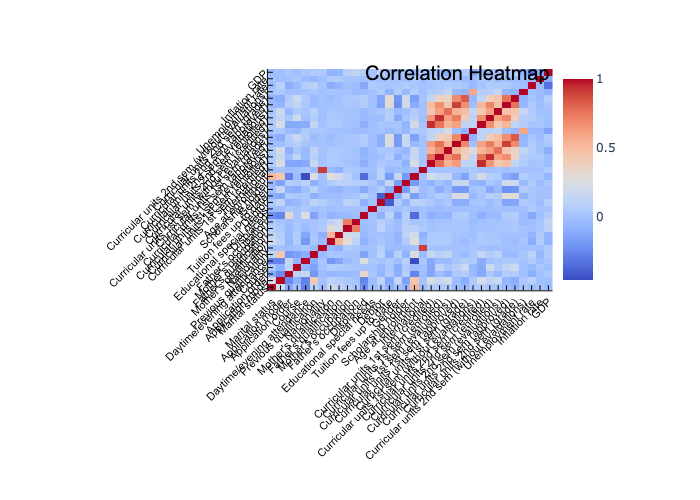

In [12]:
# Correlation Analysis (for numeric and categorical columns)
columns = names(data, Number)
if !isempty(columns)
    println("\nCorrelation Matrix (Numeric Columns):")
    correlation_matrix = cor(Matrix(select(data, columns)))
    println(correlation_matrix)

    # Plot Correlation Heatmap with Rotated Labels
    heatmap(correlation_matrix, 
            xticks=(1:length(columns), columns), 
            yticks=(1:length(columns), columns), 
            title="Correlation Heatmap", color=:coolwarm, 
            xrotation=45, yrotation=45, size=(900, 900))  # Rotate labels
else
    println("No numeric columns found for correlation analysis.")
end


Distribution of Numeric Features:


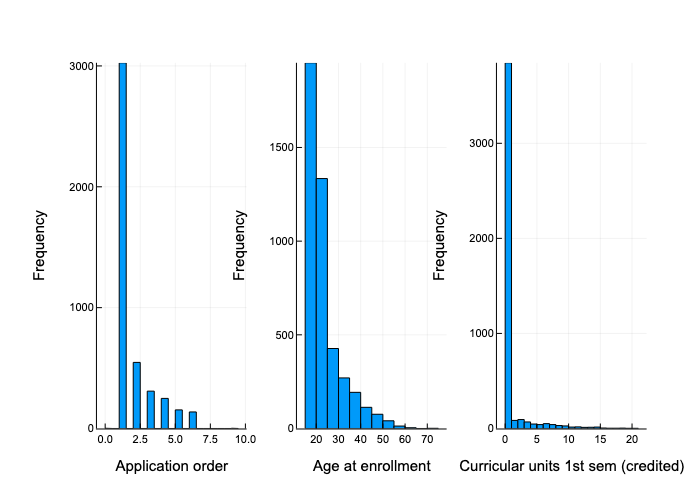

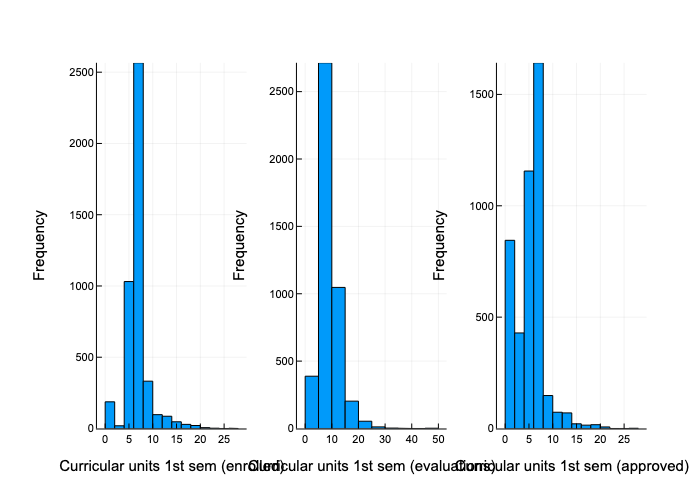

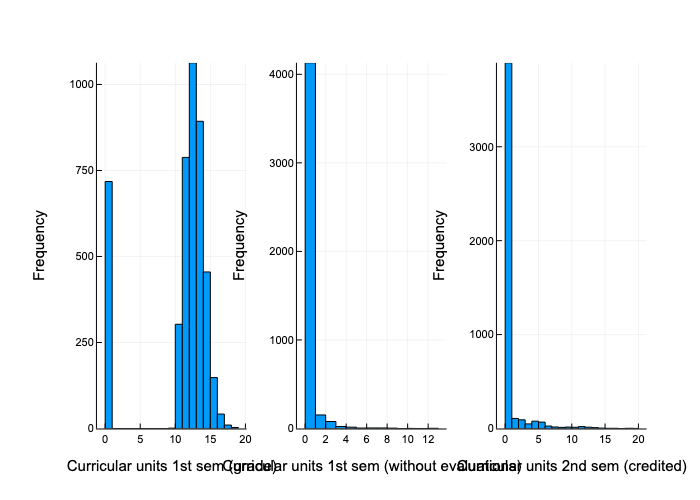

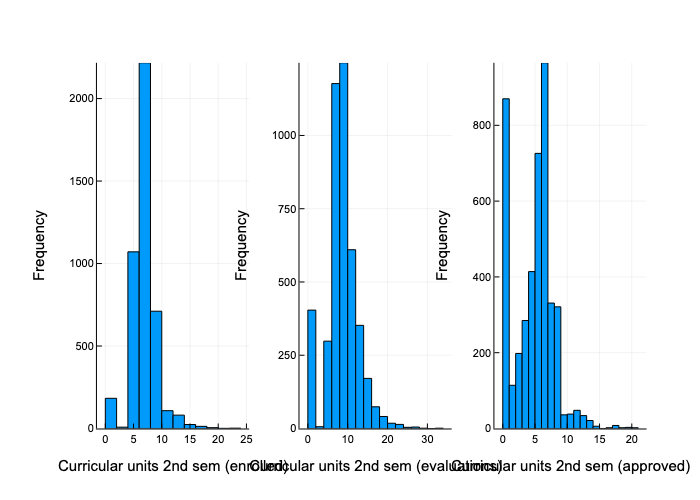

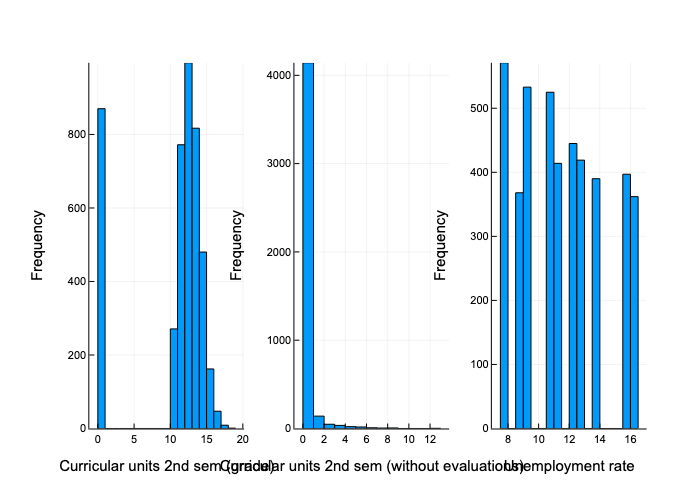

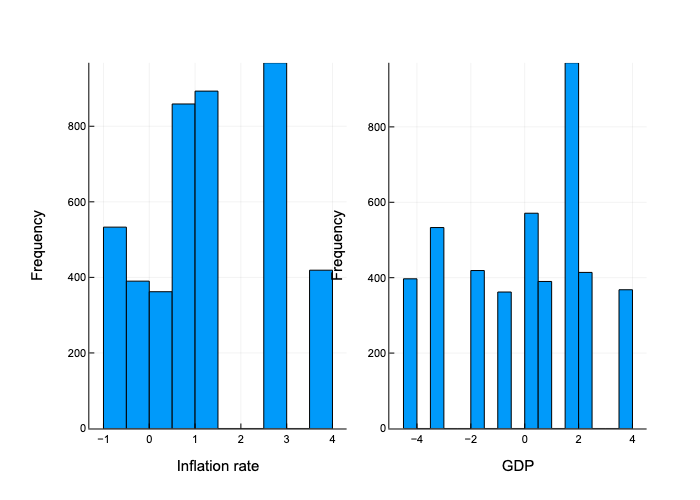

In [13]:
# Distribution of Numeric Features
println("\nDistribution of Numeric Features:")
rows_per_plot = 3  # Number of plots per row
num_plots = length(numeric_columns)
plot_list = []

for col in numeric_columns
    hist = histogram(data[!, col], bins=20, xlabel=string(col), ylabel="Frequency", legend=false)
    push!(plot_list, hist)
end

# Combine histograms into rows of 3
if !isempty(plot_list)
    for i in 1:rows_per_plot:num_plots
        display(plot(plot_list[i:min(i+rows_per_plot-1, num_plots)]...,
                     layout=(1, min(rows_per_plot, num_plots - i + 1)), size=(700, 550)))
    end
end


Categorical Feature Analysis:
Feature: Marital status
6×2 DataFrame
 Row │ Marital status  Count 
     │ Int64           Int64 
─────┼───────────────────────
   1 │              1   3919
   2 │              2    379
   3 │              3      4
   4 │              4     91
   5 │              5     25
   6 │              6      6


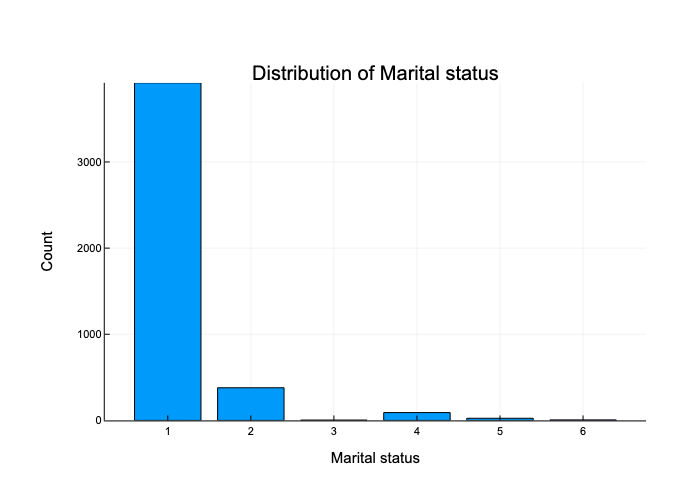

Feature: Application mode
18×2 DataFrame
 Row │ Application mode  Count 
     │ Int64             Int64 
─────┼─────────────────────────
   1 │                1   1708
   2 │                2      3
   3 │                3     16
   4 │                4    139
   5 │                5     10
   6 │                6     30
   7 │                7     38
   8 │                8    872
   9 │                9    124
  10 │               10      1
  11 │               11      1
  12 │               12    785
  13 │               13     77
  14 │               14    312
  15 │               15    213
  16 │               16     59
  17 │               17     35
  18 │               18      1


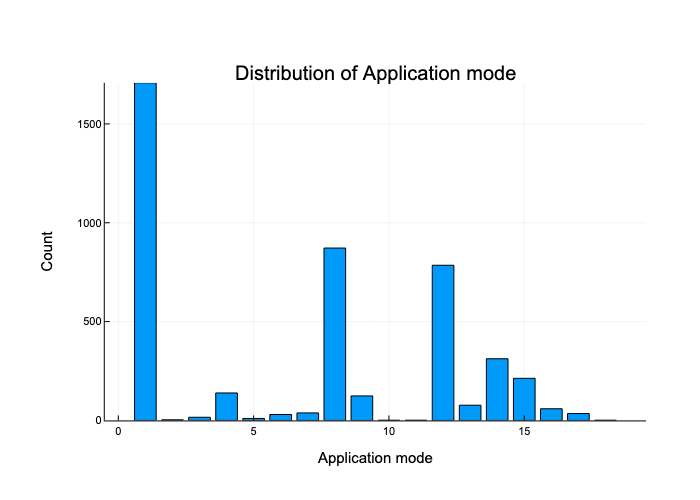

Feature: Course
17×2 DataFrame
 Row │ Course  Count 
     │ Int64   Int64 
─────┼───────────────
   1 │      1     12
   2 │      2    215
   3 │      3    215
   4 │      4    210
   5 │      5    226
   6 │      6    337
   7 │      7    170
   8 │      8    141
   9 │      9    380
  10 │     10    355
  11 │     11    252
  12 │     12    766
  13 │     13     86
  14 │     14    268
  15 │     15    331
  16 │     16    192
  17 │     17    268


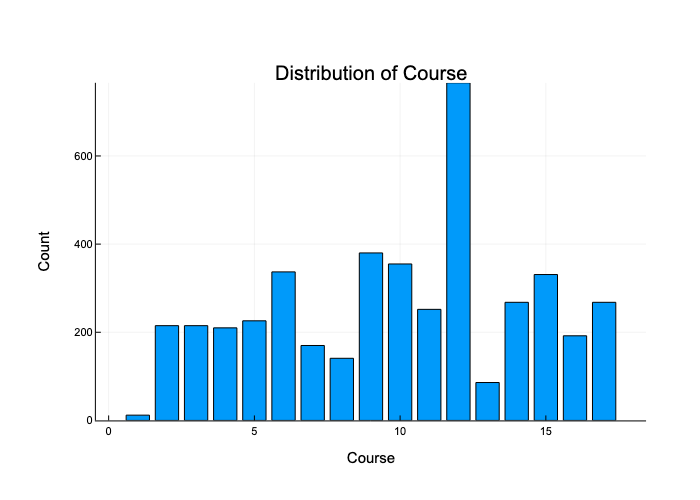

Feature: Daytime/evening attendance
2×2 DataFrame
 Row │ Daytime/evening attendance  Count 
     │ Int64                       Int64 
─────┼───────────────────────────────────
   1 │                          0    483
   2 │                          1   3941


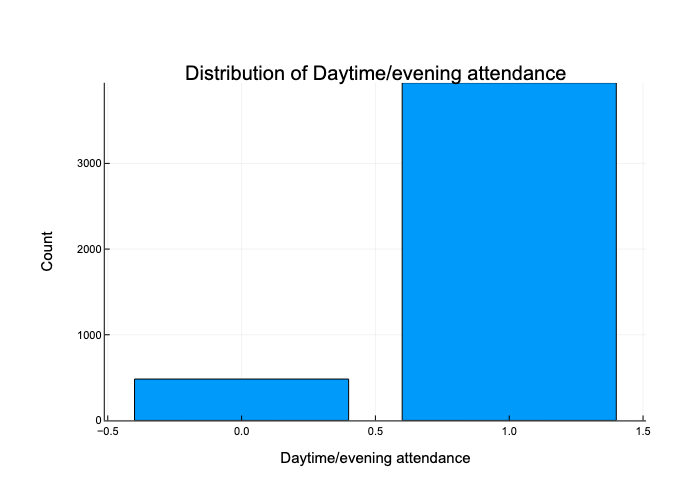

Feature: Previous qualification
17×2 DataFrame
 Row │ Previous qualification  Count 
     │ Int64                   Int64 
─────┼───────────────────────────────
   1 │                      1   3717
   2 │                      2     23
   3 │                      3    126
   4 │                      4      8
   5 │                      5      1
   6 │                      6     16
   7 │                      7     11
   8 │                      8      4
   9 │                      9     45
  10 │                     10      1
  11 │                     11      2
  12 │                     12    162
  13 │                     13      7
  14 │                     14    219
  15 │                     15     40
  16 │                     16     36
  17 │                     17      6


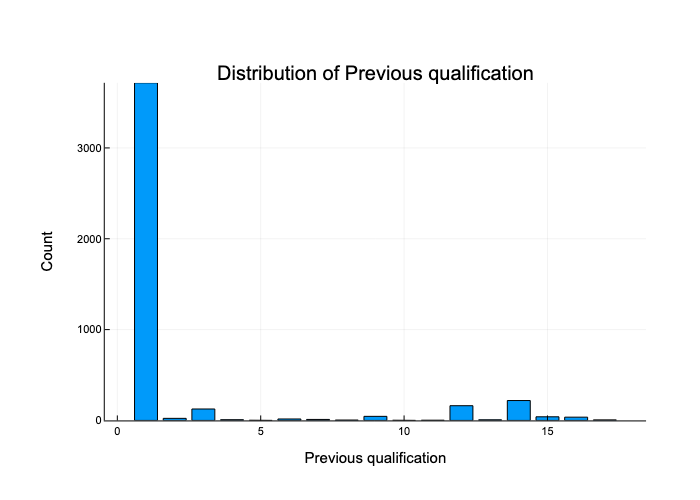

Feature: Nacionality
21×2 DataFrame
 Row │ Nacionality  Count 
     │ Int64        Int64 
─────┼────────────────────
   1 │           1   4314
   2 │           2      2
   3 │           3     13
   4 │           4      3
   5 │           5      1
   6 │           6      1
   7 │           7      1
   8 │           8      2
   9 │           9     13
  10 │          10      5
  11 │          11      2
  12 │          12     14
  13 │          13      1
  14 │          14     38
  15 │          15      2
  16 │          16      3
  17 │          17      2
  18 │          18      3
  19 │          19      2
  20 │          20      1
  21 │          21      1


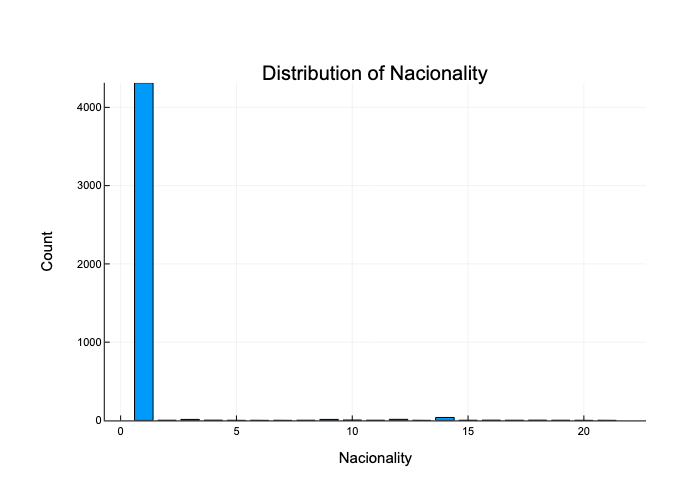

Feature: Mother's qualification
29×2 DataFrame
 Row │ Mother's qualification  Count 
     │ Int64                   Int64 
─────┼───────────────────────────────
   1 │                      1   1069
   2 │                      2     83
   3 │                      3    438
   4 │                      4     49
   5 │                      5     21
   6 │                      6      4
   7 │                      7      8
   8 │                      8      3
   9 │                      9      3
  10 │                     10     42
  11 │                     11      2
  12 │                     12      1
  13 │                     13    953
  14 │                     14      1
  15 │                     15      1
  16 │                     16      1
  17 │                     17      3
  18 │                     18      3
  19 │                     19    130
  20 │                     20      3
  21 │                     21      3
  22 │                     22   1009
  23 │                   

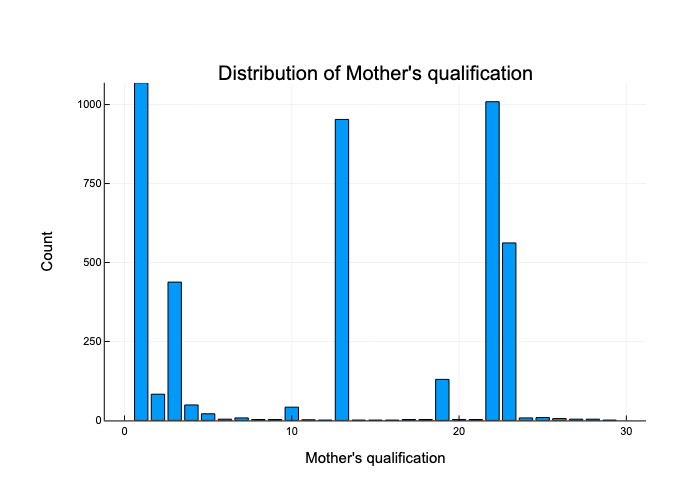

Feature: Father's qualification
34×2 DataFrame
 Row │ Father's qualification  Count 
     │ Int64                   Int64 
─────┼───────────────────────────────
   1 │                      1    904
   2 │                      2     68
   3 │                      3    282
   4 │                      4     39
   5 │                      5     18
   6 │                      6      2
   7 │                      7      5
   8 │                      8      2
   9 │                      9     10
  10 │                     10     38
  11 │                     11      1
  12 │                     12      4
  13 │                     13      1
  14 │                     14    968
  15 │                     15      1
  16 │                     16      4
  17 │                     17      1
  18 │                     18      2
  19 │                     19      1
  20 │                     20      3
  21 │                     21      4
  22 │                     22      1
  23 │                   

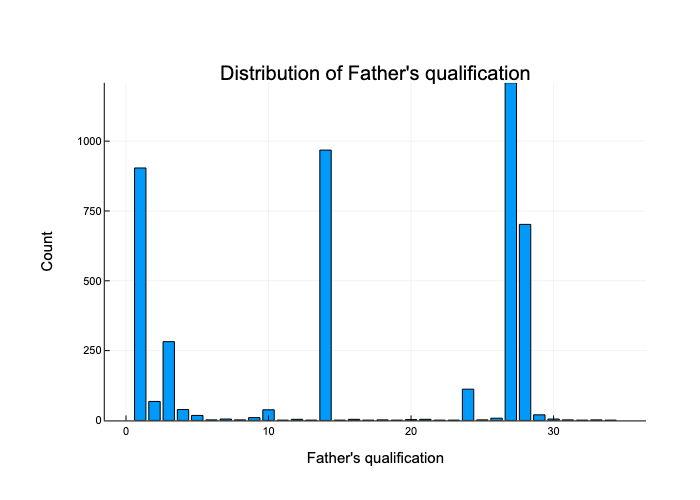

Feature: Mother's occupation
32×2 DataFrame
 Row │ Mother's occupation  Count 
     │ Int64                Int64 
─────┼────────────────────────────
   1 │                   1    144
   2 │                   2    102
   3 │                   3    318
   4 │                   4    351
   5 │                   5    817
   6 │                   6    530
   7 │                   7     91
   8 │                   8    272
   9 │                   9     36
  10 │                  10   1577
  11 │                  11      4
  12 │                  12     70
  13 │                  13     17
  14 │                  14      2
  15 │                  15      7
  16 │                  16      1
  17 │                  17      1
  18 │                  18      3
  19 │                  19      4
  20 │                  20      8
  21 │                  21      3
  22 │                  22      6
  23 │                  23      3
  24 │                  24      2
  25 │                  25      2
 

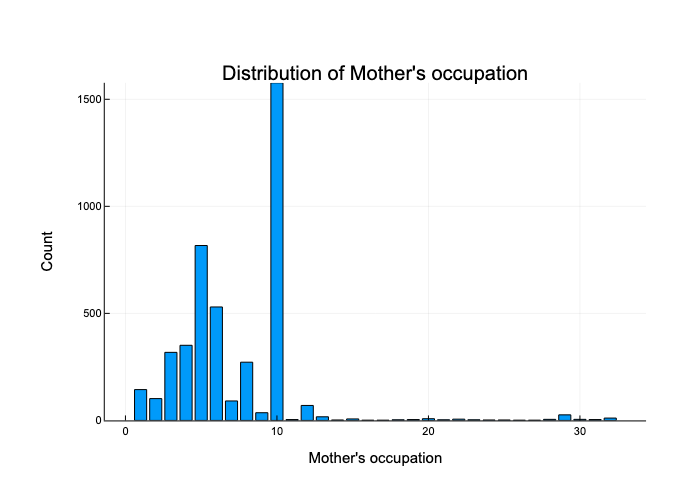

Feature: Father's occupation
46×2 DataFrame
 Row │ Father's occupation  Count 
     │ Int64                Int64 
─────┼────────────────────────────
   1 │                   1    128
   2 │                   2    134
   3 │                   3    197
   4 │                   4    384
   5 │                   5    386
   6 │                   6    516
   7 │                   7    242
   8 │                   8    666
   9 │                   9    318
  10 │                  10   1010
  11 │                  11    266
  12 │                  12     65
  13 │                  13     19
  14 │                  14      1
  15 │                  15      2
  16 │                  16      4
  17 │                  17      2
  18 │                  18      1
  19 │                  19      1
  20 │                  20      2
  21 │                  21      3
  22 │                  22      1
  23 │                  23      1
  24 │                  24      1
  25 │                  25      1
 

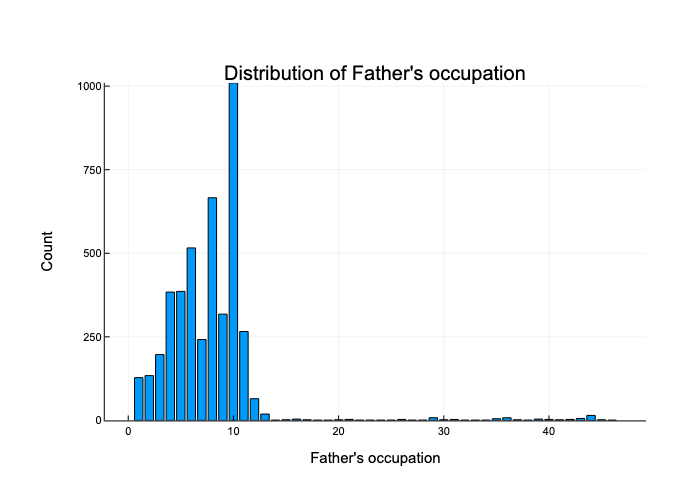

Feature: Displaced
2×2 DataFrame
 Row │ Displaced  Count 
     │ Int64      Int64 
─────┼──────────────────
   1 │         0   1998
   2 │         1   2426


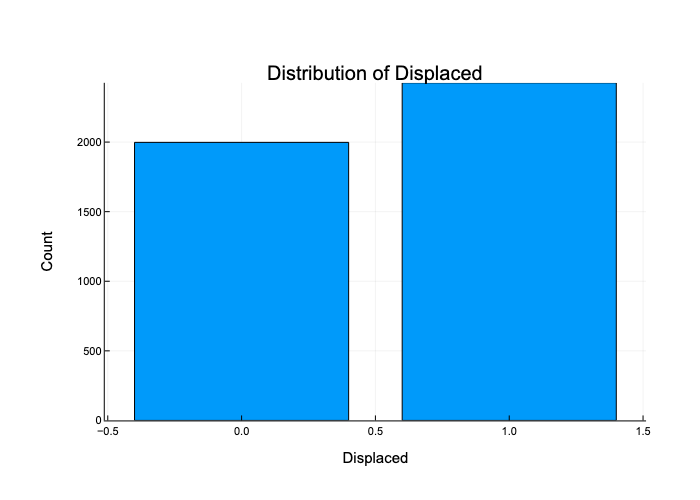

Feature: Educational special needs
2×2 DataFrame
 Row │ Educational special needs  Count 
     │ Int64                      Int64 
─────┼──────────────────────────────────
   1 │                         0   4373
   2 │                         1     51


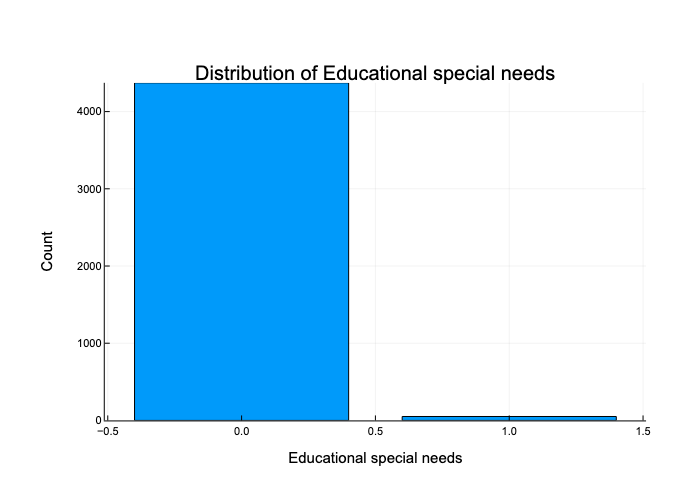

Feature: Debtor
2×2 DataFrame
 Row │ Debtor  Count 
     │ Int64   Int64 
─────┼───────────────
   1 │      0   3921
   2 │      1    503


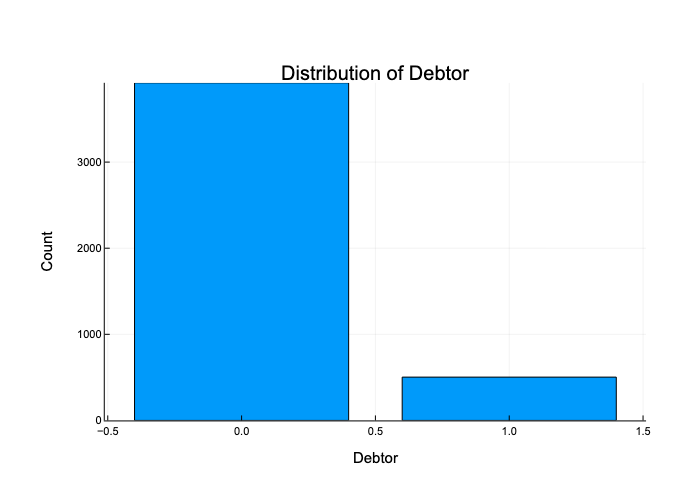

Feature: Tuition fees up to date
2×2 DataFrame
 Row │ Tuition fees up to date  Count 
     │ Int64                    Int64 
─────┼────────────────────────────────
   1 │                       0    528
   2 │                       1   3896


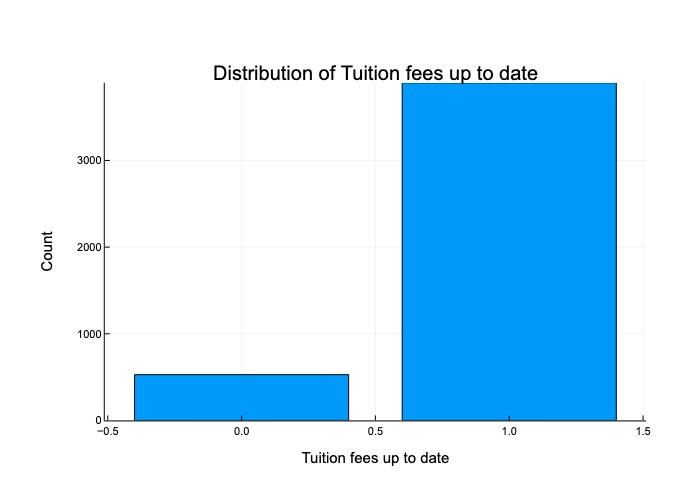

Feature: Gender
2×2 DataFrame
 Row │ Gender  Count 
     │ Int64   Int64 
─────┼───────────────
   1 │      0   2868
   2 │      1   1556


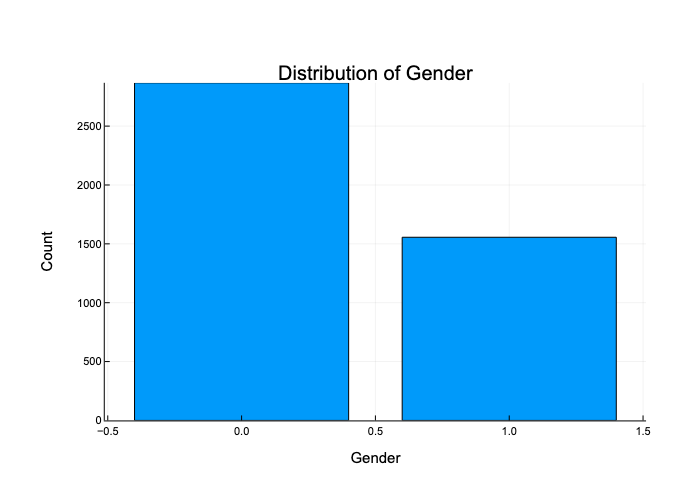

Feature: Scholarship holder
2×2 DataFrame
 Row │ Scholarship holder  Count 
     │ Int64               Int64 
─────┼───────────────────────────
   1 │                  0   3325
   2 │                  1   1099


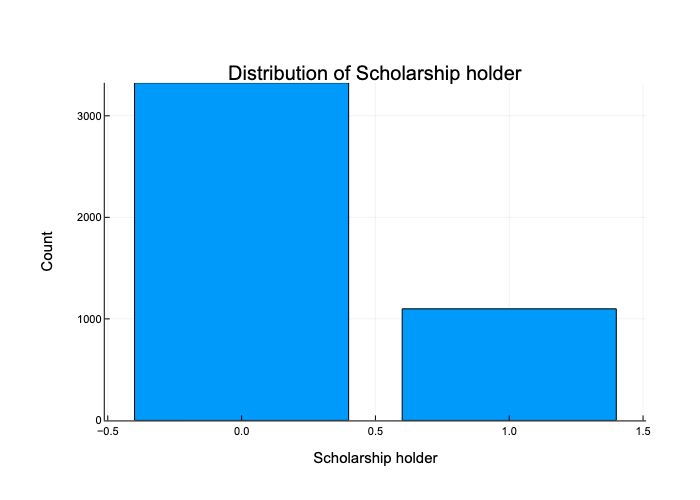

Feature: International
2×2 DataFrame
 Row │ International  Count 
     │ Int64          Int64 
─────┼──────────────────────
   1 │             0   4314
   2 │             1    110


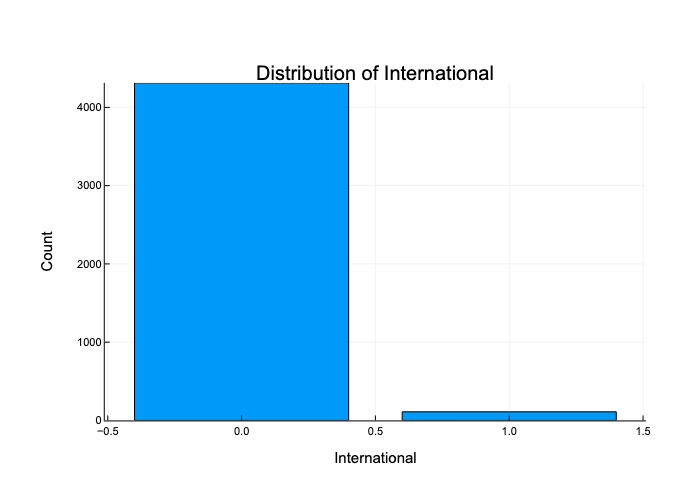

In [14]:
# Analyze Categorical Features
println("\nCategorical Feature Analysis:")
for col in categorical_columns
    println("Feature: $col")
    value_counts = combine(groupby(data, col), nrow => :Count)
    println(value_counts)

    # Plot bar chart for categorical feature
    plt = bar(value_counts[!, col], value_counts[!, :Count],
        xlabel=string(col), ylabel="Count", 
        title="Distribution of $col", legend=false)
        
    display(plt)
end

# Preprocessing

In [7]:
# One-hot encode the target column
println("Encoding the target column...")
classes = unique(targets)
targets_encoded = oneHotEncoding(targets, classes)

Encoding the target column...


4424×3 BitMatrix:
 1  0  0
 0  1  0
 1  0  0
 0  1  0
 0  1  0
 0  1  0
 0  1  0
 1  0  0
 0  1  0
 1  0  0
 ⋮     
 1  0  0
 0  1  0
 0  1  0
 0  1  0
 0  1  0
 1  0  0
 1  0  0
 0  1  0
 0  1  0

First, we split the dataset and then we normalize the data to ensure that the model is not influenced by information from the test set during training.

In [8]:
# Split the dataset into training and testing sets
println("Splitting the dataset into training, validation and test sets...")

N = nrow(data)     # Total number of samples
Ptest = 0.2       # Percentage for test set

train_indices, test_indices = holdOut(N, Ptest)

# Split the dataset
train_inputs = inputs[train_indices, :]
train_targets = targets[train_indices]

test_inputs = inputs[test_indices, :]
test_targets = targets[test_indices]

# Display sizes of each subset
println("Train size: ", size(train_inputs))
println("Test size: ", size(test_inputs))

Splitting the dataset into training, validation and test sets...
Train size: (3539, 34)
Test size: (885, 34)


For this task, we will use zero normalization as the preprocessing method for the data. The main reason is that some numerical features may not have clearly defined bounds. For example, consider the features related to curricular units categorized by enrollment, approval status, etc., in the first or second semester. Analyzing the feature *Curricular units 1st sem (evaluations)*, which represents the number of curricular units evaluated by a student in the first semester, we observe a maximum value of 45. However, in the second semester, the maximum is 33. This indicates that the range of possible values for these features is likely bounded within specific intervals.

This normalization should be done inside the cross validation function.

In [9]:
# Normalize the dataset based on the training set parameters
println("Normalizing numeric features...")

# Convert DataFrames to Matrices
train_inputs_matrix = Matrix(train_inputs)
test_inputs_matrix = Matrix(test_inputs)

# Choose normalization type (:minmax or :zeromean)
normalization_type = :zeromean

# Calculate normalization parameters using the training set
normalization_parameters = calculateNormalizationParameters(train_inputs_matrix, normalization_type)

# Normalize each set using the same parameters
train_input = performNormalization!(train_inputs_matrix, normalization_parameters, normalization_type)
test_input = performNormalization!(test_inputs_matrix, normalization_parameters, normalization_type)

Normalizing numeric features...


885×34 Matrix{Float64}:
 -0.294501   0.214525   1.68882   …   0.879222  -1.09898    0.343089
 -0.294501  -1.1055     1.68882       1.74456   -0.664202  -0.409973
  1.32388    0.968826  -0.558354     -0.81383   -1.46129   -1.37882
 -0.294501   1.53455   -0.558354      0.879222  -1.09898    0.343089
 -0.294501  -1.1055    -0.558354     -1.00195    0.132885   1.54094
 -0.294501   1.72313   -0.558354  …  -0.174233  -0.446815   0.884764
 -0.294501   0.214525  -0.558354      0.427741   1.79952   -0.753475
 -0.294501   1.34598    0.190704     -0.287103   0.132885   0.761456
 -0.294501  -1.1055    -0.558354     -0.174233  -0.446815   0.884764
 -0.294501  -1.1055    -0.558354      0.314871  -0.519277   0.783475
  ⋮                               ⋱                        
 -0.294501   0.4031    -0.558354      0.427741   1.79952   -0.753475
 -0.294501   1.34598   -0.558354     -0.287103   0.132885   0.761456
 -0.294501   0.968826  -0.558354      0.879222  -1.09898    0.343089
 -0.294501  -1.1055  

In [10]:
#@sk_import decomposition:PCA

pca = PCA(0.9)
train_inputs = Matrix(train_inputs)
test_inputs = Matrix(test_inputs)
fit!(pca, train_inputs)

pca_train = pca.transform(train_inputs)
pca_test = pca.transform(test_inputs)

println("Train Patterns ", size(train_inputs), " -> ", size(pca_train))
println("Train Patterns ", size(test_inputs), " -> ", size(pca_test))

Train Patterns (3539, 34) -> (3539, 9)
Train Patterns (885, 34) -> (885, 9)


In [11]:
# Assuming `pca`, `explained_variance_ratio`, and `loadings` are already defined:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = cumsum(explained_variance_ratio)
components = 1:length(explained_variance_ratio)

# Plot explained variance ratio
plot(
    components,
    explained_variance_ratio,
    seriestype = :scatter,
    label = "Explained Variance Ratio",
    xlabel = "Principal Component",
    ylabel = "Variance Explained",
    title = "PCA Explained Variance",
    legend = :topright,
    grid = true
)
plot!(
    components,
    cumulative_variance,
    seriestype = :line,
    label = "Cumulative Variance",
    marker = :circle
)

# Plot contribution of components (loadings) as a heatmap
loadings = pca.components_

# Heatmap of PCA loadings
heatmap(
    loadings,
    title = "PCA Component Loadings",
    xlabel = "Original Features",
    ylabel = "Principal Components",
    color = :viridis
)

# Training

In [79]:
include("metrics.jl")

confusionMatrix (generic function with 5 methods)

In [84]:
include("training.jl")

trainClassEnsemble (generic function with 13 methods)

## Without PCA

In [12]:
# Generate k-fold indices
k = 5  # Number of folds
N = size(inputs, 1)
Random.seed!(42)  # For reproducibility
fold_indices = crossValidation(targets, k)

inputs = Float32.(Matrix(inputs))

# Specify the model and hyperparameters
# Define modelos a probar
models = [
    (:ANN, Dict(
        "topology" => [32, 32],
        "learningRate" => 0.01,
        "maxEpochs" => 100,
        "minLoss" => 0.01,
        "repetitionsTraining" => 10,
        "validationRatio" => 0.2,
        "maxEpochsVal" => 10,
    )),
    (:SVM, Dict(
        :kernel => "linear",
        :C => 1.0,
        :gamma => "auto",
    )),
    (:KNN, Dict(
        :n_neighbors => 5,
        :weights => "uniform",
        :metric => "euclidean",
    )),
    (:DecisionTree, Dict(
        :max_depth => 5,
        :criterion => "gini",
        :min_samples_split => 2,
    ))
]

# Metrics to evaluate
metrics_to_save = [:f1_score, :precision, :recall]

# Train and evaluate each model
results = Dict{Symbol, Any}()

for (model_type, model_hyperparameters) in models
    println("Training model: $model_type")
    
    # Perform cross-validation
    mean_results, std_results = modelCrossValidation(
        model_type,
        model_hyperparameters,
        inputs,
        targets,
        fold_indices,
        metrics_to_save;
        normalizationType=:zeromean,
    )
    
    # Save results
    results[model_type] = Dict(
        :mean => mean_results,
        :std => std_results
    )
end

# Print results for each model
for (model_type, metrics) in results
    println("\nResults for model $model_type:")
    for metric in metrics_to_save
        println("  $(metric): mean = $(metrics[:mean][metric]), std = $(metrics[:std][metric])")
    end
end

Training model: ANN
Mean results for fold 1:
	f1_score: 0.7557728959814333
		Class 1: 0.7867543004087851
		Class 2: 0.8594207289819614
		Class 3: 0.41211225165420773
	precision: 0.7536566919274506
		Class 1: 0.8157817992720366
		Class 2: 0.8008067265384577
		Class 3: 0.5112292020452347
	recall: 0.7695259593679458
		Class 1: 0.76
		Class 2: 0.9273755656108598
		Class 3: 0.34779874213836476
Mean results for fold 2:
	f1_score: 0.7559406231391304
		Class 1: 0.7969480260061599
		Class 2: 0.8558643217831762
		Class 3: 0.40491938279381856
	precision: 0.7541687769471384
		Class 1: 0.820741407971237
		Class 2: 0.7939387620736778
		Class 3: 0.5247036157095636
	recall: 0.7715254237288137
		Class 1: 0.7746478873239435
		Class 2: 0.9282805429864254
		Class 3: 0.330188679245283
Mean results for fold 3:
	f1_score: 0.74831167805255
		Class 1: 0.7946529612794422
		Class 2: 0.8505624876085681
		Class 3: 0.3812941795607418
	precision: 0.7430926414495477
		Class 1: 0.8018716095864665
		Class 2: 0.80185891

In [19]:
# Confire ensemble type and hyperparameters
ensemble_type = :Voting  # Ensemble de votación
ensemble_hyperparameters = Dict("voting" => "hard")  # Votación "hard" o "soft"

# Metrics to evaluate
metrics_to_save = ["f1_score", "precision", "recall"]

# Convert models to estimators and hyperparameters
estimators = [model[1] for model in models]
models_hyperparameters = [model[2] for model in models]

# Dataset for training the ensemble
trainingDataset = (inputs, targets_encoded)

# Train ensemble with Voting
println("Training ensemble with Voting...")
results_fold = trainClassEnsemble(
    estimators,
    models_hyperparameters,
    trainingDataset,
    fold_indices;
    ensembleType=ensemble_type,
    ensembleHyperParameters=ensemble_hyperparameters,
    metricsToSave=metrics_to_save,
    showText=true,
    normalizationType=:zeromean,
)

# Prints the results of the ensemble
println("\nFinal Ensemble Results:")
for metric in metrics_to_save
    println("  $(metric): mean = $(mean(results_fold[metric])), std = $(std(results_fold[metric]))")
end

Training ensemble with Voting...


MethodError: MethodError: no method matching trainClassEnsemble(::Vector{Symbol}, ::Vector{Dict{K, Any} where K}, ::Tuple{Matrix{Float32}, BitMatrix}, ::Vector{Int64}; ensembleType::Symbol, ensembleHyperParameters::Dict{String, String}, metricsToSave::Vector{String}, showText::Bool, normalizationType::Symbol)
The function `trainClassEnsemble` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  trainClassEnsemble(::AbstractVector{Symbol}, !Matched::Vector{Dict}, ::Tuple{AbstractMatrix{<:Real}, AbstractMatrix{Bool}}, ::Vector{Int64}) got unsupported keyword arguments "ensembleType", "ensembleHyperParameters", "metricsToSave", "showText", "normalizationType"
   @ Main c:\Users\NACHO\Desktop\Olga\Máster\Primer semestre\ML\Final-Project-MaLea\training.jl:906
  trainClassEnsemble(::AbstractVector{Symbol}, !Matched::Vector{Dict}, ::Tuple{AbstractMatrix{<:Real}, AbstractMatrix{Bool}}, ::Vector{Int64}, !Matched::Symbol) got unsupported keyword arguments "ensembleType", "ensembleHyperParameters", "metricsToSave", "showText", "normalizationType"
   @ Main c:\Users\NACHO\Desktop\Olga\Máster\Primer semestre\ML\Final-Project-MaLea\training.jl:906
  trainClassEnsemble(::AbstractVector{Symbol}, !Matched::Vector{Dict}, ::Tuple{AbstractMatrix{<:Real}, AbstractMatrix{Bool}}, ::Vector{Int64}, !Matched::Symbol, !Matched::Dict) got unsupported keyword arguments "ensembleType", "ensembleHyperParameters", "metricsToSave", "showText", "normalizationType"
   @ Main c:\Users\NACHO\Desktop\Olga\Máster\Primer semestre\ML\Final-Project-MaLea\training.jl:906
  ...


## With PCA

In [15]:
# Generate k-fold indices
k = 5  # Number of folds
N = size(inputs, 1)
Random.seed!(42)  # For reproducibility
fold_indices = crossValidation(targets, k)

inputs = Float32.(Matrix(inputs))

# Only taking the numeric columns
# inputs_num = Float32.(Matrix(data[!, numeric_columns]))

# Specify the model and hyperparameters
# Define modelos a probar
models = [
    (:ANN, Dict(
        "topology" => [32, 32],
        "learningRate" => 0.01,
        "maxEpochs" => 100,
        "minLoss" => 0.01,
        "repetitionsTraining" => 10,
        "validationRatio" => 0.2,
        "maxEpochsVal" => 10,
    )),
    (:SVM, Dict(
        :kernel => "linear",
        :C => 1.0,
        :gamma => "auto",
    )),
    (:KNN, Dict(
        :n_neighbors => 5,
        :weights => "uniform",
        :metric => "euclidean",
    )),
    (:DecisionTree, Dict(
        :max_depth => 5,
        :criterion => "gini",
        :min_samples_split => 2,
    ))
]

# Metrics to evaluate
metrics_to_save = [:f1_score, :precision, :recall]

# Train and evaluate each model
results = Dict{Symbol, Any}()

for (model_type, model_hyperparameters) in models
    println("Training model: $model_type")
    
    # Perform cross-validation
    mean_results, std_results = modelCrossValidation(
        model_type,
        model_hyperparameters,
        inputs,
        targets,
        fold_indices,
        metrics_to_save;
        normalizationType=:zeromean,
        applyPCA = true,
    )
    
    # Save results
    results[model_type] = Dict(
        :mean => mean_results,
        :std => std_results
    )
end

# Print results for each model
for (model_type, metrics) in results
    println("\nResults for model $model_type:")
    for metric in metrics_to_save
        println("  $(metric): mean = $(metrics[:mean][metric]), std = $(metrics[:std][metric])")
    end
end

Training model: ANN
Mean results for fold 1:
	f1_score: 0.7406533966651832
		Class 1: 0.7676359271692117
		Class 2: 0.848160411490742
		Class 3: 0.3934325051774782
	precision: 0.7367032392086215
		Class 1: 0.7936858581790185
		Class 2: 0.7953071809831794
		Class 3: 0.47165299599530297
	recall: 0.7531602708803613
		Class 1: 0.7435087719298245
		Class 2: 0.9085972850678734
		Class 3: 0.3383647798742138
Mean results for fold 2:
	f1_score: 0.7378726127740005
		Class 1: 0.7752058640069399
		Class 2: 0.845967838214207
		Class 3: 0.3706981914235221
	precision: 0.7364073799962383
		Class 1: 0.7928909911754884
		Class 2: 0.782887254700567
		Class 3: 0.5063102089634061
	recall: 0.756271186440678
		Class 1: 0.7595070422535212
		Class 2: 0.9201357466063349
		Class 3: 0.29496855345911943
Mean results for fold 3:
	f1_score: 0.7322162897135474
		Class 1: 0.7946803286941198
		Class 2: 0.8338493766571867
		Class 3: 0.3381181041816536
	precision: 0.7267816906705112
		Class 1: 0.7969767144219432
		Class 